# Risk Premia Portfolio Backtest

In this notebook we backtest a couple of classic long-only risk premia harvesting strategies:

1. Capital weighted
2. Equal Risk Contribution (ERC) weighted

Rebalancing in both strategies occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

Profits are re-invested.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the trade buffer limit is considered optimal.

In [50]:
import os
import sys
import importlib
from pathlib import PurePath
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [51]:
# Import local modules
sys.path.append(str(PurePath(os.getcwd()).parent))

import alphasim.backtest as bt
importlib.reload(bt)

import alphasim.stats as stats
importlib.reload(stats)

<module 'alphasim.stats' from '/Users/richklee/repos/github.com/richklee/alphasim/alphasim/stats.py'>

In [52]:
# Download price data for our universe
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2005-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2005-01-03,41.982761,51.069038,43.020000
2005-01-04,41.423946,50.533794,42.740002
2005-01-05,41.137375,50.804298,42.669998
2005-01-06,41.334389,50.838818,42.150002
2005-01-07,41.201851,50.953915,41.840000
...,...,...,...
2022-10-14,179.419998,98.570000,152.979996
2022-10-17,184.210007,98.089996,153.419998
2022-10-18,186.460007,98.320000,153.750000


## Dollar Weighted

Define equal dollar weights for our portfolio.

In [53]:
dollar_weight_df = price_df.copy()
dollar_weight_df[:] = [0.333, 0.333, 0.333]

## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [54]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

# Calc required time series
ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()
cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [55]:
# Function to calculate ERC weights for each period
def calc_erc_weight(initial_weights, cov_mat, b):
    if np.isnan(initial_weights).any():
        n = len(initial_weights)
        initial_weights = np.full(n, len(initial_weights)/n)
    w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    return w

In [56]:
# Define our risk budget as equal risk
risk_budget = np.full(ticker_n, 1/ticker_n)

# Get ERC weights
erc_weight_df = ret_df[:-1].copy()
erc_weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(
    erc_weight_df.shift(1).values, cov_mat, repeat(risk_budget))]
erc_weight_df = erc_weight_df.dropna()
display(erc_weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2005-01-04,0.366664,0.149161,0.484175
2005-01-05,0.219050,0.126429,0.654521
2005-01-06,0.199071,0.114422,0.686508
2005-01-07,0.212983,0.214996,0.572021
2005-01-10,0.282470,0.234211,0.483318
...,...,...,...
2022-10-13,0.263419,0.339244,0.397337
2022-10-14,0.257043,0.343898,0.399059
2022-10-17,0.255539,0.344108,0.400353


## Backtest

In [57]:
# Define a simple fixed minimum commission scheme whereby every trade costs 10 of the quote currency
def fixed_commission(trade_price, trade_size):
    return 10

In [58]:
# Execute our backtest for the dollar weighted strategy
dw_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=dollar_weight_df,
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=fixed_commission,
    initial_capital=10000,
    do_reinvest=True)

In [59]:
# Align the length of prices and weights
price_df = price_df.align(erc_weight_df, axis=0, join='inner')[0]

# Execute our backtest for the ERC strategy
erc_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=erc_weight_df,
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=fixed_commission,
    initial_capital=10000,
    do_reinvest=True)

In [60]:
# Compare performance stats
dw_stat_df = stats.calc_stats(dw_result_df)
erc_stat_df = stats.calc_stats(erc_result_df)
display(pd.concat([dw_stat_df, erc_stat_df], keys=["dollar_weighted", "erc_weighted"], axis=1))

,dollar_weighted,erc_weighted
,result,result
start,2005-01-03 00:00:00,2005-01-04 00:00:00
end,2022-10-20 00:00:00,2022-10-19 00:00:00
initial,10000.0,10000.0
final,36239.947438,42447.221352
profit,26239.947438,32447.221352
cagr,0.075079,0.084717
ann_volatility,0.095412,0.083143
ann_sharpe,0.786886,1.018934
commission,390.0,1970.0


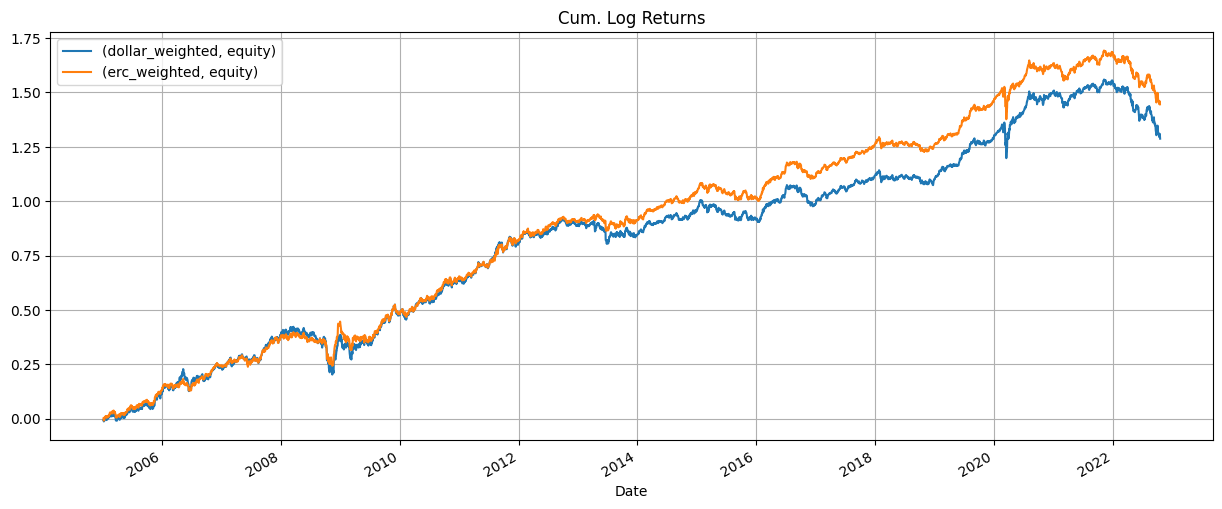

In [61]:
cum_sum_df = pd.concat([
    stats.calc_log_returns(dw_result_df).cumsum(),
    stats.calc_log_returns(erc_result_df).cumsum()
], keys=["dollar_weighted", "erc_weighted"], axis = 1)

ax = cum_sum_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

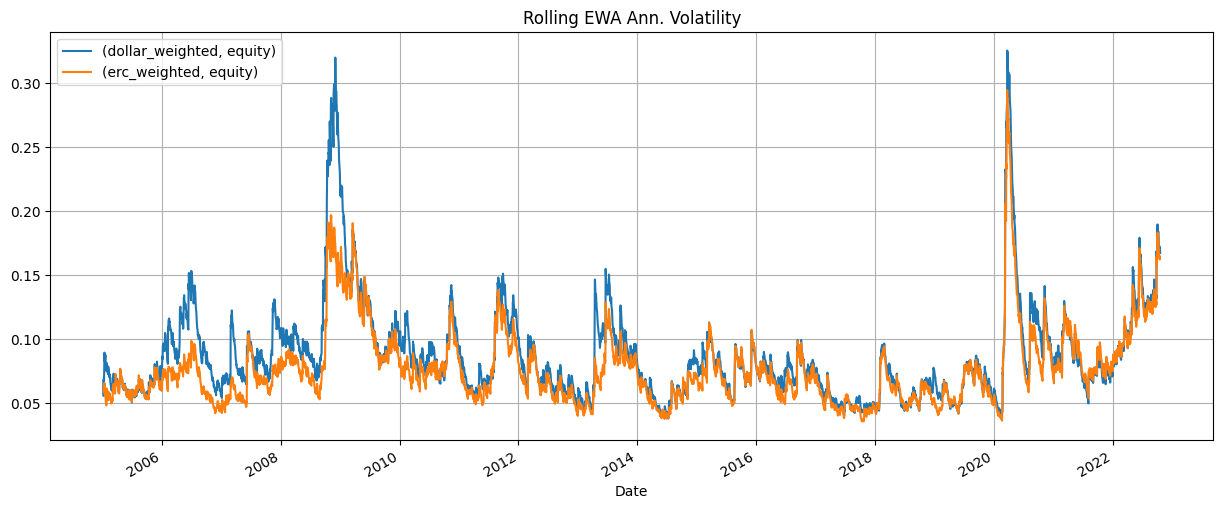

In [62]:
vola_df = pd.concat([
    stats.calc_rolling_ann_vola(dw_result_df),
    stats.calc_rolling_ann_vola(erc_result_df),
], keys=["dollar_weighted", "erc_weighted"], axis = 1)

ax = vola_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()

## Conclusions

Despite the drag on profit from the extra trading costs, the ERC strategy enjoys better risk-adjusted returns than the simpler dollar weighted strategy.

This is in part due to the lower volatility of the ERC strategy.